## COMP2006: Graded Lab 4

In this lab, you will gain some experience in dealing with missing data and further practice converting non-numeric features in a dataset to numeric.

**Target**: to predict `Comb Unadj FE - Conventional Fuel`

**Data set**: make sure you use the data assigned to your group!

| Groups | Data set |
| :-: | :-: |
| 1 | veh1_missing.csv |
| 2 | veh2_missing.csv |
| 3 | veh3_missing.csv |
| 4 | veh4_missing.csv |
| 5 | veh5_missing.csv |
| 6 | veh6_missing.csv |
| 7 | veh7_missing.csv |
| 8 | veh8_missing.csv |
| 10 | veh10_missing.csv |

**Important Notes:**
- Use [Chapter 7](https://mlbook.explained.ai/bulldozer-intro.html) of the textbook as a **guide**:
     - you only need to use **random forest** models;
- Use the **out-of-bag score** to evaluate models
     - Read Section 5.2 carefully so that you use this method properly
     - The oob score that you provide should be the average of 10 runs
- Code submitted for this lab should be:
     - error free
         - to make sure this is the case, before submitting, close all Jupyter notebooks, exit Anaconda, reload the lab notebook and execute all cells
     - final code
         - this means that I don't want to see every piece of code you try as you work through this lab but only the final code; only the code that fulfills the objective

> **Don't make assumptions!**


### Part 0

### Group Number 7
 - Manuel Bishop Noriega - ID 4362207
 - Robert E. Matney III - ID: 4364229

     

## **Part 1 - Create and evaluate an initial model**

In this part you should: 
 - use Section 7.3 of the textbook as a guide, except:
     - use all of the data; and
     - use 150 decision trees in your random forest models
 - read in the data
 - isolate all numeric features from original data set
 - fill in any missing values with 0
 - create and evaluate a baseline model 

#### Code (10 marks)

### **Importing libraries and setting up some useful functions**

In [91]:
import pandas as pd
# from rfpimp import *
from rfpimp_MC import *
from pandas.api.types import is_string_dtype, is_object_dtype
from sklearn.ensemble import RandomForestRegressor
import warnings # to avoid some warnings about plots
warnings.filterwarnings('ignore')

# ------------------------------- HELPER FUNCTIONS ----------------------------------
# to prevent repeating code we'll create an evaluation function called evalute
# it will take features and target as parameters and use them to
# create and fit a random forest regressor model and calculate it's oob performance
# it returns a tuple with rf model and its oob average from 10 runs
def evaluate(X,y):
    
    oob_scores = []
    for i in range(10):
        rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
        rf.fit(X, y)
        oob_scores.append(rf.oob_score_)
    oob=sum(oob_scores) / len(oob_scores)
    print(f'Mean OOB score: {oob}')
    print(f'{rfnnodes(rf):,d} tree nodes and {np.median(rfmaxdepths(rf))} median tree height')

    return rf, oob

# showimp() show features importances, it accepts up to 4 params
# rf: a randomforest regressor
# X,y are the features and target
# features, I added this to perform different tests while converting non-numeric features
# plots the features' importances graphic
def showimp(rf,X,y):
    I=importances(rf,X,y)
    plot_importances(I,color='blue')

# we took this function from book, useful to quickly identify most obvious missing values in dataset
def sniff(df):
    # with pd.option_context("display.max_colwidth",20):
        info=pd.DataFrame()
        #info['sample']=df.iloc[120] #no needed here
        info['data type']=df.dtypes
        info['percent missing']=df.isnull().sum()*100/len(df)
        return info.sort_values('data type')

In [92]:
# PART ONE
#-------------------------- reading the data ----------------------
df_raw = pd.read_csv("veh7_missing.csv")
df=df_raw.copy() # let's keep a safe copy of our oringal data set


### **First, let's take a look of our data set**

In [93]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1196 entries, 0 to 1195
Data columns (total 12 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Eng Displ                                                  831 non-null    float64
 1   # Cyl                                                      1196 non-null   int64  
 2   Comb Unadj FE - Conventional Fuel                          1196 non-null   object 
 3   # Gears                                                    1196 non-null   int64  
 4   Max Ethanol % - Gasoline                                   1164 non-null   float64
 5   Intake Valves Per Cyl                                      1196 non-null   int64  
 6   Exhaust Valves Per Cyl                                     1196 non-null   int64  
 7   Stop/Start System (Engine Management System)  Description  1196 non-null   object 
 8   Lockup T

,Eng Displ,# Cyl,Comb Unadj FE - Conventional Fuel,# Gears,Max Ethanol % - Gasoline,Intake Valves Per Cyl,Exhaust Valves Per Cyl,Stop/Start System (Engine Management System) Description,Lockup Torque Converter,Calc Approach Desc,Cyl Deact?,Trans Creeper Gear
0,4.4,8,20.538,7,10.0,2,2,Yes,,not filled in,^^,N
1,2.0,4,34.5365,6,15.0,2,2,No,NaN,not filled in,^^,N
2,3.4,6,31.5932,7,10.0,2,2,none,N,not filled in,N,N
3,4.4,8,22.0246,6,10.0,2,2,none,N,Derived 5-cycle label,N,N
4,4.3,6,25.772,6,85.0,1,1,No,NaN,not filled in,^^,N


In [94]:
sniff(df) # this function taken from book tells us the percentage of missing values in features

,data type,percent missing
# Cyl,int64,0.000000
# Gears,int64,0.000000
Intake Valves Per Cyl,int64,0.000000
Exhaust Valves Per Cyl,int64,0.000000
Eng Displ,float64,30.518395
Max Ethanol % - Gasoline,float64,2.675585
Comb Unadj FE - Conventional Fuel,object,0.000000
Stop/Start System (Engine Management System) Description,object,0.000000
Lockup Torque Converter,object,18.979933
Calc Approach Desc,object,0.000000


***
It seems that we have some missing values in our dataset. We know that because info() shows how many non-nulls value are in every column (if the number is lower than total entries then we have some nulls), head() lets us take a look of data we have in the dataset too. Sniff function is another tool to overview data set by returning a percentage of missing values per feature. But because we want to quickly build our baseline model, let's just use numeric features by now and fill in missing values with 0 and keep going with building and evaluating baseline model.

**NOTE:**
 After doing the above, while trying to fit our model we got an error `ValueError: could not convert string to float: 'Mod'` then we realized that target feature was shown as `object dtype` in df.info() even when values seem to be all float, after a closer look we found some missing values hidden behind 'Mod' string in our target feature. Then, given they were missing values too, we just proceeded as instructed and replaced them with value 0.
***

In [170]:
# ---------------------------- pulling out numeric features and filling in missing values with 0 -----------------------------------
df_num=df.select_dtypes(include=['number']) 
num_features=df_num.columns.tolist()
df_num=df_num.fillna(0)
df_num.isna().any() # to confirm there're no more missing values

Eng Displ                   False
# Cyl                       False
# Gears                     False
Max Ethanol % - Gasoline    False
Intake Valves Per Cyl       False
Exhaust Valves Per Cyl      False
dtype: bool

In [164]:
# ----------------------------- pulling out target feature and filling in missing values with 0 too -------------------------------------
y=pd.to_numeric(df['Comb Unadj FE - Conventional Fuel'],errors='coerce',downcast='float') # if it's not a number then replace it with NaN
target_feature=['Comb Unadj FE - Conventional Fuel']
y=y.fillna(0) # can't have missing values in y, then fill in them with 0

### **Creating and evaluating BASELINE model**

Mean OOB score: 0.6984276225057894
37,330 tree nodes and 15.0 median tree height


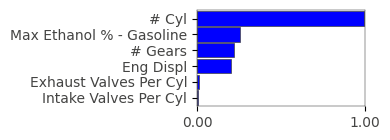

In [97]:
rf,oob=evaluate(df_num,y)
showimp(rf,df_num,y)


## **Part 2 - Normalize missing values**

In this part you should: 
 - use Section 7.4 of the textbook as a guide
 - convert **all** representations of missing data to a **single** representation
 
#### Code (15 marks)

***
**ONCE Baseline model was created and tested** we'll clean data as much as possible and try to get improve results.

Because apparently there are no outliers or any other inconsistencies in numeric features and missing values were converted to 0, we'll check now non numeric features to identify all missing values and then normalize all of them to NaN.
***

In [157]:
df_nonum=df.drop(num_features+target_feature,axis=1)
for col in df_nonum.columns:
    print(f'{col} unique values {df_nonum[col].unique()}')

Stop/Start System (Engine Management System)  Description unique values ['Yes' 'No' 'none']
Lockup Torque Converter unique values ['   ' nan 'N' 'Y']
Calc Approach Desc unique values ['not filled in' 'Derived 5-cycle label' 'Vehicle Specific 5-cycle label'
 'Derived Vehicle Specific 5-cycle Calculation Approach for city label but Modified 5-cycle Calculation Approach for Highway label']
Cyl Deact? unique values ['^^' 'N' 'Y']
Trans Creeper Gear unique values ['N' 'Y']


***
We found missing values in non-numeric features in the form of 'none', '', nan, 'not filled in', '^^'. we'll convert them all to NaN
***

In [195]:
# --------------- normalizing missing values to NaN in non numeric features -----------------
missing_values_str=['none','   ','not filled in','^^']
for col in df_nonum.columns:
    df_nonum[col]=df_nonum[col].str.lower()
    df_nonum[col]=df_nonum[col].fillna(np.nan)
    df_nonum[col]=df_nonum[col].replace(missing_values_str, np.nan)

# ------------------ let's normalize missing values in numeric features too -----------------
for col in df_num.columns:
    df_num[col]=df_num[col].replace(0,np.nan)

# now put features all together and check their values
df_norm=pd.concat([df_num,df_nonum],axis=1)
for col in df_norm.columns:
    print(df_norm[col].unique())
df_norm

[4.4 2.  3.4 4.3 3.  4.7 3.7 3.5 nan 2.5 3.8 1.8 1.6 6.3 1.3 2.7 5.5 1.4
 6.2 3.3 6.4 5.2 2.4 6.5 5.3 4.6 3.6 4.5 6.7 5.  6.  3.2 5.6 1.  4.  1.5
 5.4 5.7 4.8 1.2 7.  6.6 6.8 5.9 4.2]
[ 8  4  6 12  5 10  3 16]
[7 6 8 1 5 4 9]
[10. 15. 85. nan]
[2 1]
[2 1]
['yes' 'no' nan]
[nan 'n' 'y']
[nan 'derived 5-cycle label' 'vehicle specific 5-cycle label'
 'derived vehicle specific 5-cycle calculation approach for city label but modified 5-cycle calculation approach for highway label']
[nan 'n' 'y']
['n' 'y']


,Eng Displ,# Cyl,# Gears,Max Ethanol % - Gasoline,Intake Valves Per Cyl,Exhaust Valves Per Cyl,Stop/Start System (Engine Management System) Description,Lockup Torque Converter,Calc Approach Desc,Cyl Deact?,Trans Creeper Gear
0,4.4,8,7,10.0,2,2,yes,NaN,NaN,NaN,n
1,2.0,4,6,15.0,2,2,no,NaN,NaN,NaN,n
2,3.4,6,7,10.0,2,2,NaN,n,NaN,n,n
3,4.4,8,6,10.0,2,2,NaN,n,derived 5-cycle label,n,n
4,4.3,6,6,85.0,1,1,no,NaN,NaN,NaN,n
...,...,...,...,...,...,...,...,...,...,...,...
1191,NaN,6,8,10.0,2,2,yes,y,NaN,NaN,n
1192,4.4,8,8,10.0,2,2,yes,y,NaN,n,n
1193,NaN,4,6,10.0,2,2,no,NaN,derived 5-cycle label,n,n
1194,2.0,4,6,10.0,2,2,NaN,n,derived 5-cycle label,n,n


In [188]:
df_norm.info()
print(df_norm.nunique(axis=0))
sniff(df_norm)


<class 'pandas.core.frame.DataFrame'>
Index: 2392 entries, 0 to 1195
Data columns (total 11 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Eng Displ                                                  831 non-null    float64
 1   # Cyl                                                      1196 non-null   float64
 2   # Gears                                                    1196 non-null   float64
 3   Max Ethanol % - Gasoline                                   1164 non-null   float64
 4   Intake Valves Per Cyl                                      1196 non-null   float64
 5   Exhaust Valves Per Cyl                                     1196 non-null   float64
 6   Stop/Start System (Engine Management System)  Description  828 non-null    object 
 7   Lockup Torque Converter                                    669 non-null    object 
 8   Calc Approach

,data type,percent missing
Eng Displ,float64,65.259197
# Cyl,float64,50.000000
# Gears,float64,50.000000
Max Ethanol % - Gasoline,float64,51.337793
Intake Valves Per Cyl,float64,50.000000
Exhaust Valves Per Cyl,float64,50.000000
Stop/Start System (Engine Management System) Description,object,65.384615
Lockup Torque Converter,object,72.031773
Calc Approach Desc,object,65.760870
Cyl Deact?,object,72.115385


#### Question (5 marks)

Note here all the different ways missing data was represented in the data.   

**Enter your answer here:**

### Part 3 - Categorical features

In this part you should: 
 - use Section 7.5.1 as a guide
 - only use ordinal encoding 
 - convert **all** non-numeric features to numeric 
 - handle any missing values
 
#### Code (25 marks)

### Part 4 - Numeric features

In this part you should: 
 - use Section 7.5.2 as a guide
 - handle any missing values
 
#### Code (30 marks)

### Part 5 - Create and evaluate a final model

In this part you should:
 - create and evaluate a model using all the features after processing them in Parts 2, 3, and 4 above 

#### Code (10 marks)

#### Questions (5 marks)

Provide answers to the following:
 1. calculate the percent difference between the results of Part 1 and Part 5 (make sure you are using the correct formula for percent difference) 
 2. based on the percent difference, state whether or not the results of Part 5 are an improvement over the results of Part 1

**Enter your answers here:**